# Fase 1.5: Inferencia con la CNN utilizando el acelerador Hailo 8L

In [1]:
# Imports

from multiprocessing import Process

import numpy as np
import torch

from hailo_platform import (
    HEF,
    ConfigureParams,
    FormatType,
    HailoSchedulingAlgorithm,
    HailoStreamInterface,
    InferVStreams,
    InputVStreamParams,
    InputVStreams,
    OutputVStreamParams,
    OutputVStreams,
    VDevice,
)

# from hailo_sdk_client import ClientRunner, InferenceContext

import time
import os

# Funciones y parámetros de la CNN base
import sys
sys.path.append('../src/')
import resbagan_networks
import resbagan_datasets
from cnn21_pix import read_pgm, save_pgm

import matplotlib.pyplot as plt

## 1. Inferencia mediante flujo independiente

### 1.1. Definición de parámetros

In [2]:
# Setting VDevice params to disable the HailoRT service feature
params = VDevice.create_params()
params.scheduling_algorithm = HailoSchedulingAlgorithm.NONE

# The target can be used as a context manager ("with" statement) to ensure it's released on time.
# Here it's avoided for the sake of simplicity
target = VDevice(params=params)

# Loading compiled HEFs to device:
optimization_level = 1
compression_level = 0
model_name = f"../results/models/model_ResBaGAN_discriminator_o{optimization_level}_c{compression_level}"
hef_path = f"{model_name}.hef"
hef = HEF(hef_path)

# Get the "network groups" (connectivity groups, aka. "different networks") information from the .hef
configure_params = ConfigureParams.create_from_hef(hef=hef, interface=HailoStreamInterface.PCIe)
network_groups = target.configure(hef, configure_params)
network_group = network_groups[0]
network_group_params = network_group.create_params()

# Create input and output virtual streams params
# Quantized argument signifies whether or not the incoming data is already quantized.
# Data is quantized by HailoRT if and only if quantized == False .
input_vstreams_params = InputVStreamParams.make(network_group, quantized=False, format_type=FormatType.FLOAT32)
output_vstreams_params = OutputVStreamParams.make(network_group, quantized=True, format_type=FormatType.UINT8)

# Obtener información de entrada/salida
input_vstream_info = hef.get_input_vstream_infos()[0]
output_vstream_info = hef.get_output_vstream_infos()[0]
image_height, image_width, num_bands = input_vstream_info.shape

### 1.2. Carga del dataset y ejecución de la inferencia

In [4]:
# Cargar el dataset y ejecutar la inferencia

# Se mide el tiempo total de carga y ejecución
start_time = time.time()

# Definir parámetros

DATASET='../data/imagenes_rios/oitaven_river.raw'
GT='../data/imagenes_rios/oitaven_river.pgm'

# Queremos usar todos los datos para la inferencia
SAMPLES=[0.0,0.0]

os.environ['HAILO_MONITOR'] = '1'

# Carga de datos para la inferencia en el discriminador
dataset = resbagan_datasets.HyperDataset(
    "oitaven_river", segmented=False, patch_size=32, ratios=(SAMPLES[0], SAMPLES[1]))

# Almacenamos las dimensiones en variables
H = dataset.height
V = dataset.width

samples = dataset.ordered_test_set['samples']

# Obtenemos el array de gt
truth = dataset.gt.flatten()
# Obtenemos un array de indices para test
test = dataset.test_index_list

# Obtenemos el numero de clases y el numero de clases no vacias para test
nclases = dataset.classes_count
nclases_no_vacias = 0
for i in range(nclases):
    clase_actual = i + 1
    if any(truth[idx] == clase_actual for idx in test):
        nclases_no_vacias += 1

print(dataset)

# The custom HyperDataset object contains all the train, validation and test data
#   --> But it will wrapped into a PyTorch data feeder for convenience
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=100,
    shuffle=False,
    num_workers=4,
    pin_memory=False,
)

# Ejecutar la inferencia

output=np.zeros(H*V, dtype=np.uint8)

# Modo evaluación
dataset.to_test()

# Realizar la predicción
with InferVStreams(network_group, input_vstreams_params, output_vstreams_params) as infer_pipeline:
    with network_group.activate(network_group_params):
        total=0
        for batch_id, (inputs, labels, targets_pixel_level) in enumerate(data_loader):
            
            # Convertir inputs a un formato adecuado para hailo
            inputs_np = inputs.numpy()
            inputs_hailo = np.transpose(inputs_np, (0, 2, 3, 1))

            # Asegurarse de que los datos sean contiguos en memoria
            inputs_hailo = np.ascontiguousarray(inputs_hailo.astype(np.float32))
            
            # Realizar la inferencia
            input_data = {input_vstream_info.name: inputs_hailo}
            
            infer_results = infer_pipeline.infer(input_data)
            output_hailo = infer_results[output_vstream_info.name]
            output_hailo_formatted = np.delete(output_hailo, dataset.classes_count, axis=-1) # Se deshabilita la clase fake para test

            predicted=np.argmax(output_hailo_formatted, axis=-1)

            for i in range(len(predicted)):
                output[test[total+i]]=np.uint8(predicted[i]+1)
            total+=labels.size(0)
            if(total%100000==0): print('  Test:',total,'/', len(dataset))

end_time = time.time()

print("Prediction time: {:.4f} seconds".format(end_time - start_time))

[*] Loading dataset oitaven_river from disk
	oitaven_river dataset is in RAW format
[*] Recording available classes
[*] Starting preprocessing
[*] Scaling dataset to [-1, 1]
[*] Splitting dataset into train, validation, and test sets: ratios (0.0, 0.0)
[*] Total samples: 6067179
	[*] Recording samples for class Water (309248 items)
	[*] Recording samples for class Bare soil (113324 items)
	[*] Recording samples for class Rock (79152 items)
	[*] Recording samples for class Asphalt (43861 items)
	[*] Recording samples for class Concrete (128022 items)
	[*] Recording samples for class Tiles (78785 items)
	[*] Recording samples for class Meadows (2428482 items)
	[*] Recording samples for class Native trees (1829360 items)
	[*] Recording samples for class Pines (193884 items)
	[*] Recording samples for class Eucalyptus (863061 items)

[*] HyperDataset summary:
	Name: oitaven_river
	Shape: (height) 6689, (width) 6722, (bands) 5
	Classes: ['Water', 'Bare soil', 'Rock', 'Asphalt', 'Concrete', 

In [5]:
# Guardar el output

np.save(f'../results/predictions/predictions_rpi_ResBaGAN_discriminator_o{optimization_level}_c{compression_level}.npy', output)

In [ ]:
# Cargar el output

output = np.load(f'../results/predictions/predictions_rpi_ResBaGAN_discriminator_o{optimization_level}_c{compression_level}.npy')

### 1.3. Evaluación del desempeño del modelo

In [6]:
# Evaluar el desempeño del modelo

# Precisiones a nivel de clase
correct=0; total=0; AA=0; OA=0
class_correct=[0]*(nclases+1)
class_total=[0]*(nclases+1)
class_aa=[0]*(nclases+1)

for i in test:
    if(output[i]==0 or truth[i]==0): continue
    total+=1; class_total[truth[i]]+=1
    if(output[i]==truth[i]):
          correct+=1
          class_correct[truth[i]]+=1
for i in range(1,nclases+1):
    if(class_total[i]!=0): class_aa[i]=100*class_correct[i]/class_total[i]
    else: class_aa[i]=0
    AA+=class_aa[i]
OA=100*correct/total; AA=AA/nclases_no_vacias

for i in range(1,nclases+1): print('  Class %02d: %02.02f'%(i,class_aa[i]))
print('* Accuracy (pixels) OA=%02.02f, AA=%02.02f'%(OA,AA))
print('  total:',total,'correct:',correct)

  Class 01: 98.68
  Class 02: 52.63
  Class 03: 0.01
  Class 04: 46.53
  Class 05: 63.10
  Class 06: 78.26
  Class 07: 97.56
  Class 08: 58.27
  Class 09: 95.34
  Class 10: 94.79
* Accuracy (pixels) OA=81.85, AA=68.52
  total: 6067179 correct: 4965762


In [7]:
# Guardar la salida

save_pgm(output,V,H,nclases,f'../results/predictions/predictions_rpi_ResBaGAN_discriminator_o{optimization_level}_c{compression_level}.pgm')

* Saved file: ../results/predictions/predictions_rpi_ResBaGAN_discriminator_o1_c0.pgm


* Read GT: ../results/predictions/predictions_rpi_ResBaGAN_discriminator_o1_c0.pgm
  H: 6722 V: 6689 depth: 10
  Read: 44963458


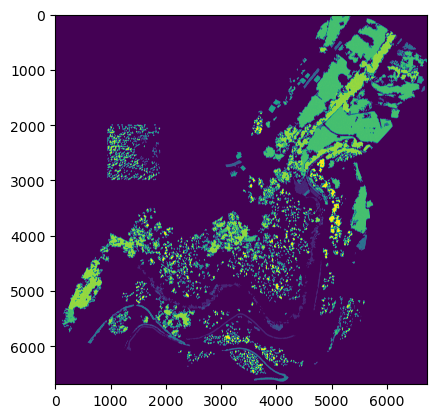

In [8]:
# Mostrar la salida

OUTPUT=f'../results/predictions/predictions_rpi_ResBaGAN_discriminator_o{optimization_level}_c{compression_level}.pgm'

(imagen_output, H, V) = read_pgm(OUTPUT)

# Convertir la lista a array y redimensionar
imagen_output = np.array(imagen_output, dtype=np.uint8).reshape(V, H)

# Mostrar la imagen
plt.imshow(imagen_output)
plt.show()